<a href="https://colab.research.google.com/github/chaitraDev/GenAI-for-marketing/blob/main/Cognizant_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import pandas as pd

In [ ]:
customers = pd.read_csv("/content/drive/MyDrive/Cognizant/fake_cust.csv")

In [ ]:
customers.columns

Index(['CustomerID', 'CustGender', 'Age', 'Income', 'Num_Transactions',
       'Cibil_Score', 'most_recent', 'Gap', 'Sum_Transactions', 'Recency',
       'Frequency', 'Monetary_Value', 'RFM_Score', 'Relationship_Value'],
      dtype='object')

In [ ]:
# the columns we need gender, age, income, cibil, relationship value
customers_req = customers[['CustGender', 'Age', 'Income','Cibil_Score', 'Relationship_Value']]

In [ ]:
customers[customers.Relationship_Value.isnull()]

,CustomerID,CustGender,Age,Income,Num_Transactions,Cibil_Score,most_recent,Gap,Sum_Transactions,Recency,Frequency,Monetary_Value,RFM_Score,Relationship_Value


# Transforming

In [ ]:
customers_req.select_dtypes('O').columns

Index(['CustGender', 'Relationship_Value'], dtype='object')

- Relationship_Value is ordinal
- Gender is nominal

## Gender Column

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
OHE = OneHotEncoder()
encoded = OHE.fit_transform(customers_req[["CustGender"]]).toarray()
# customers_req["Gender(num)"] = OHE.fit_transform(customers_req[["CustGender"]])

In [ ]:
print(encoded[0])
customers_req["CustGender"].iloc[0]
#encoded as (female,male)

[0. 1.]


'Male'

In [ ]:
customers_req.loc[:,"IsFemale"] = encoded[:,0]
customers_req[["CustGender","IsFemale"]].head(2)

<ipython-input-10-81c9c70dffab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_req.loc[:,"IsFemale"] = encoded[:,0]


,CustGender,IsFemale
0,Male,0.0
1,Female,1.0


## Relationship value column

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# lbl_encoder = LabelEncoder()
# customers_req.loc[:,"Relationship_Value(num)"] = lbl_encoder.fit_transform(customers_req["Relationship_Value"])
customers_req.loc[:,"Relationship_Value(num)"] = customers_req["Relationship_Value"].map({"high":2,"med":1,"low":0})

<ipython-input-11-f1de21af0a84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_req.loc[:,"Relationship_Value(num)"] = customers_req["Relationship_Value"].map({"high":2,"med":1,"low":0})


In [ ]:
customers_req[["Relationship_Value","Relationship_Value(num)"]].head(4)

,Relationship_Value,Relationship_Value(num)
0,high,2
1,high,2
2,high,2
3,med,1


In [ ]:
customers_req.columns

Index(['CustGender', 'Age', 'Income', 'Cibil_Score', 'Relationship_Value',
       'IsFemale', 'Relationship_Value(num)'],
      dtype='object')

# Normalization

In [ ]:
cust_numeric = customers_req[["Age","Income","Cibil_Score","Relationship_Value(num)"]]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cust_numeric = pd.DataFrame(scaler.fit_transform(cust_numeric),columns=cust_numeric.columns)

In [ ]:
cust_numeric.isnull().sum()

,0
Age,0
Income,0
Cibil_Score,0
Relationship_Value(num),0


# K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

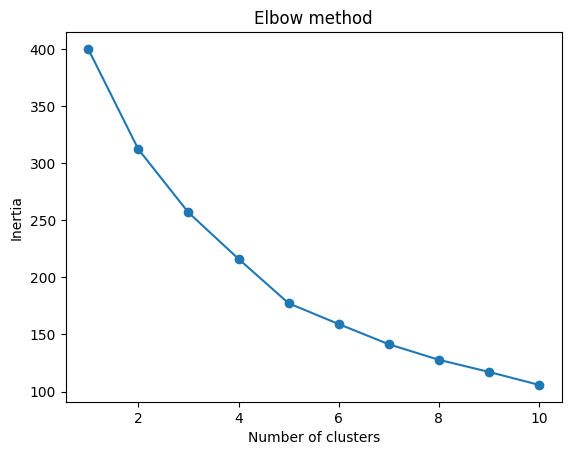

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cust_numeric)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

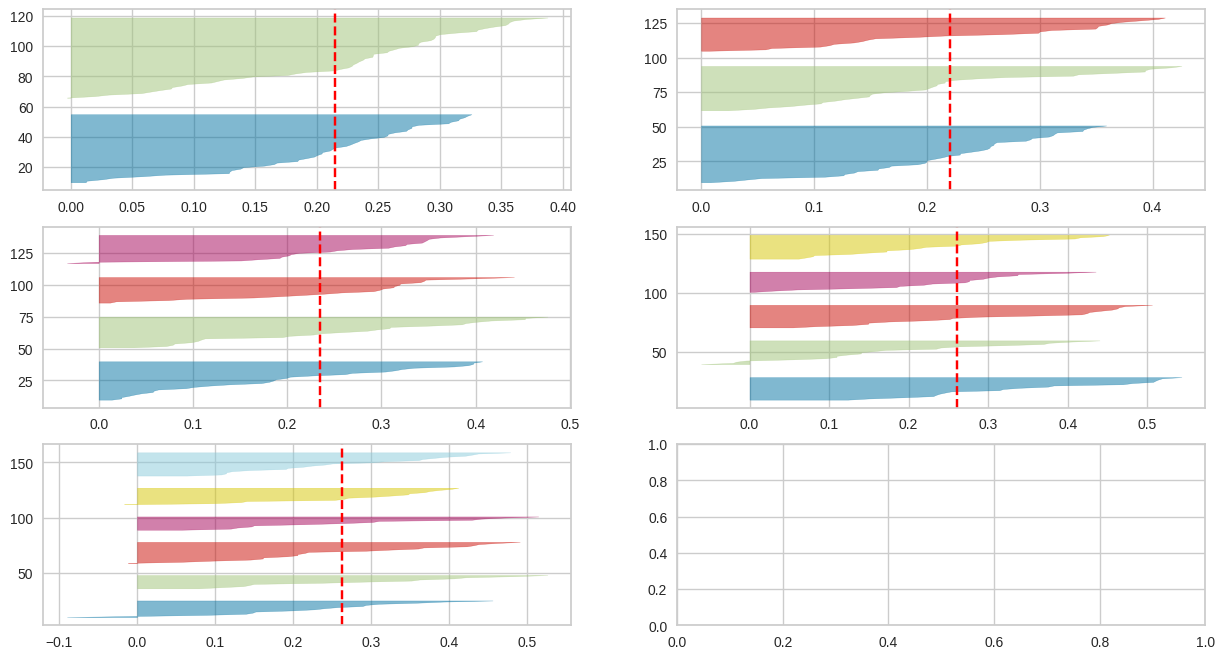

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
X = cust_numeric

for i in range(2,7):
  km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
  q, mod = divmod(i, 2)
  '''
  Create SilhouetteVisualizer instance with KMeans instance
  Fit the visualizer
  '''
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
  visualizer.fit(X)

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
def score_kmeans(k):
  kmeans = KMeans(k,random_state=42)
  kmeans.fit(X)
  # kmeans.labels_
  # customers["Cluster"] = kmeans.labels_
  return silhouette_score(X,kmeans.labels_)

In [ ]:
for k in range(2,5):
  print(k,score_kmeans(k))

2 0.21470697800636313
3 0.22096359205309654
4 0.23451612468360816


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
kmeans = KMeans(5,random_state=144)
kmeans.fit(X)
clusters = kmeans.labels_
cust_numeric["clusters"] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
cust_numeric.clusters

,clusters
0,1
1,1
2,1
3,2
4,3
...,...
95,2
96,2
97,1
98,3


In [ ]:
grouped = cust_numeric.groupby("clusters")